In [1]:
import pandas as pd

import os 
import pandas as pd
    
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import allel
import itertools
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib

from math import pi
import scipy

import matplotlib.patches as mpatches
import re


import matplotlib.colors as clr
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import collections  as mc
import matplotlib.lines as mlines

import re

In [2]:
df = pd.read_csv("../../results/data/processed_hmf_escape_info.tsv.gz",sep="\t") # Supp. Table 4, Hartwig
df_pcawg = pd.read_csv("../../results/data/processed_pcawg_escape_info.tsv.gz",sep="\t") # Supp Table 4, PCAWG
df_meta = pd.read_csv("../../metadata/dataset_metadata_supp_table3.tsv",sep="\t") # Supp. Table 3

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (16,17,19,20,142) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Visualization functions

In [3]:
def plot_hla(gene,total_cds,d_h,summary,cohort="HMF",ylim=8,synonymous=False):
    colors={"missense_variant/inframe_variant":"#66c2a5","truncating_variant":"#fc8d62","splice_variant":"#8da0cb","synonymous":"grey"}
    residues=np.array(list(set([31,83,86,87,90,183,187,191,195,31,33,48,69,86,87,90,91,94,123,183,94,121,123,138,180,183,90,182,183,187,93,94,182,93,94,97,98,121,180,93,97,121,138,171,174,176,180,97,100,101,171,98,101,104,105,108,119,121,140,142,167,171])))*3

    fig,ax = plt.subplots(figsize=(10,4))

    ax.axhline(y=-0.4,xmin=0,xmax=total_cds,color="black",lw=5)

    ax.set_ylim(-2,ylim+2)
    ax.set_xlim(-1,total_cds+1)

    # plot domains
    for region in d_h["regions"]:
        start,end,text,descr=(region["start"]*3,region["end"]*3,region["text"],region["metadata"]["description"])
        rect=mpatches.Rectangle(xy=(start,-0.8),width=end-start,height=1,zorder=3,color="#888888")
                            # Add the patch to the Axes
        ax.annotate(xy=((start+((end-start)/2)),-0.4),s=text,fontsize=14)
        ax.add_patch(rect)

    # mutations
    mut_gene=summary.loc[gene]
    if not(synonymous):
        mut_gene=mut_gene[mut_gene["type_mut"]!="synonymous"]
    else:
        mut_gene=mut_gene[mut_gene["type_mut"]=="synonymous"]
    for csq in mut_gene["type_mut"].unique():
        color=colors[csq]
        for i,r in mut_gene[mut_gene["type_mut"]==csq].iterrows():
            try:
                ax.bar(x=int(r["cds_pos"]),height=r["sample_id"],color=color,width=3.5)
                ax.scatter(x=int(r["cds_pos"]),y=r["sample_id"],s=80,color=color,edgecolors="black",lw=1.,zorder=3)
            except ValueError:
                continue
    # highlit residues involved in binding

    for res in residues:
        ax.scatter(x=res,y=-1.5,color="#cc0000",marker="_",s=70)


    ax.set_title(gene,fontsize=14)
    ax.set_ylabel(f"Number of observed mutations \n ({cohort} cohort)",fontsize=12)
    ax.set_xlabel("CDS pos",fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=12)
    if not synonymous:
        plt.savefig(f'../../results/figures/figure3/needle_{gene}_{cohort}.pdf', dpi=800,bbox_inches="tight")
    else:
        plt.savefig(f'../../results/figures/figure3/needle_{gene}_{cohort}_syn.pdf', dpi=800,bbox_inches="tight")
def get_type_mut(csq):
    if "missense_variant" in csq or "inframe_insertion" in csq or "inframe_deletion" in csq:
        return "missense_variant/inframe_variant"
    elif "stop_gained" in csq or "frameshift_variant" in csq or "stop_lost" in csq:
        return "truncating_variant"
    elif "splice_acceptor_variant" in csq or "splice_donor_variant" in csq or "splice_region_variant" in csq: 
        return "splice_variant"
    elif "synonymous_variant" in csq:
        return "synonymous"
    else:
        return "other"

### Process output LILAC for somatic mutations in HLA-I genes in Hartwig dataset

In [ ]:
lilac_hartwig="/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/lilac"

In [4]:
df_met = df[(df["cohort"]=="Hartwig")&(df["is_selected"])]
print (df_met.shape[0])

m=re.compile("PURPLE_AF=([0-9\.]+)")
m1=re.compile("PURPLE_VCN=([0-9\.]+)")
l=[]
lenghts={}
for sample in tqdm(df_met["sample_id"].values):
    if not(os.path.exists(f"{lilac_hartwig}/{sample}/{sample}.lilac.somatic.vcf.gz")):
        continue
    try:
        dq = pd.read_csv(f"{lilac_hartwig}/{sample}/{sample}.lilac.somatic.vcf.gz",sep="\t",skiprows=94)
    except:
        dq = pd.read_csv(f"{lilac_hartwig}/{sample}/{sample}.lilac.somatic.vcf.gz",sep="\t",skiprows=97) # Some samples did not include the full header, this is a minor bug in LILAC that will be corrected in future versions
    for i,r in dq.iterrows():
        csq,gene,cds_pos,protein_pos = map(r["INFO"].split("|").__getitem__,[1,3,12,13])
        caf = float(m.search(r["INFO"])[1])
        vcn = float(m1.search(r["INFO"])[1])
        vaf = float(r[sample].split(":")[2])
        pos,ref,alt=r["POS"],r["REF"],r["ALT"]
        if not(gene) in lenghts:
            lenghts[gene] = (protein_pos.split("/")[1],cds_pos.split("/")[1])
        l.append([gene,csq,sample,protein_pos.split("/")[0],cds_pos.split("/")[0],caf,vcn,vaf,pos,ref,alt])
df_muts_hla = pd.DataFrame(l,columns=["gene","csq","sample_id","protein_pos","cds_pos","purple_vaf","variant_cn","raw_vaf","position","ref","alt"])
df_muts_hla["type_mut"] = df_muts_hla.apply(lambda row: get_type_mut(row["csq"]),axis=1)
summary=df_muts_hla.groupby(["gene","type_mut","cds_pos"]).agg({"sample_id":"count"}).reset_index().set_index(["gene"])

  0%|          | 1/4439 [00:00<12:04,  6.13it/s]

4439


100%|██████████| 4439/4439 [06:43<00:00, 10.99it/s]


### Recurrent frameshift info (for reviewer's comment)

In [5]:
df_meta[df_meta["sample_id"].isin(df_muts_hla[df_muts_hla["cds_pos"]=="621"]["sample_id"])][["sample_id","msi_status"]]

,sample_id,msi_status
1081,CPCT02120042T,MSI
1133,DRUP01010018T,MSI
1740,WIDE01010578T,MSI
2689,CPCT02030546T,MSI
2861,CPCT02011050T,MSI
4421,DRUP01010123T,MSI


In [6]:
df_muts_hla[(df_muts_hla["cds_pos"]=="621")&(df_muts_hla["gene"]=="HLA-A")].merge(df_meta[["sample_id","sample_id_2","msi_status","cancer_type"]]).drop(["sample_id","variant_cn"],axis=1).rename(columns={"sample_id_2":"sample_id"})

,gene,csq,protein_pos,cds_pos,purple_vaf,raw_vaf,position,ref,alt,type_mut,sample_id,msi_status,cancer_type
0,HLA-A,frameshift_variant&splice_region_variant,207,621,0.3927,0.160,29911899,A,AC,truncating_variant,HMF004509A,MSI,CUP
1,HLA-A,frameshift_variant&splice_region_variant,207,621,0.5163,0.264,29911899,AC,A,truncating_variant,HMF004249A,MSI,Small intestine cancer
2,HLA-A,frameshift_variant&splice_region_variant,207,621,0.8210,0.452,29911899,AC,A,truncating_variant,HMF001099A,MSI,Colorectum carcinoma
3,HLA-A,frameshift_variant&splice_region_variant,207,621,0.6004,0.306,29911899,A,AC,truncating_variant,HMF000644A,MSI,Colorectum carcinoma
4,HLA-A,frameshift_variant&splice_region_variant,207,621,0.3355,0.171,29911899,AC,A,truncating_variant,HMF000644A,MSI,Colorectum carcinoma
5,HLA-A,frameshift_variant&splice_region_variant,207,621,0.4049,0.264,29911899,A,AC,truncating_variant,HMF002548A,MSI,Non small cell lung cancer
6,HLA-A,frameshift_variant&splice_region_variant,207,621,0.4021,0.176,29911899,AC,A,truncating_variant,HMF004149A,MSI,Non small cell lung cancer


In [7]:
df_meta[df_meta["sample_id"].isin(df_muts_hla[(df_muts_hla["cds_pos"]=="19")&(df_muts_hla["gene"]=="HLA-B")]["sample_id"])][["sample_id_2","msi_status"]]

,sample_id_2,msi_status
1052,HMF000512B,MSI
1081,HMF000644A,MSI
1334,HMF002628A,MSI
1593,HMF004703A,MSS
2698,HMF002693A,MSI


### Plot non-synonymous variants

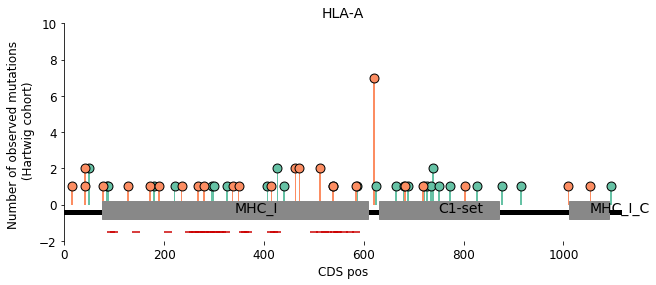

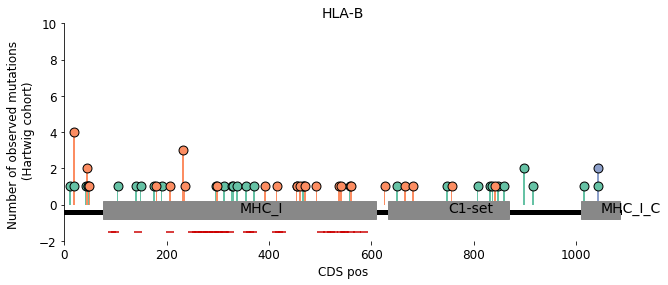

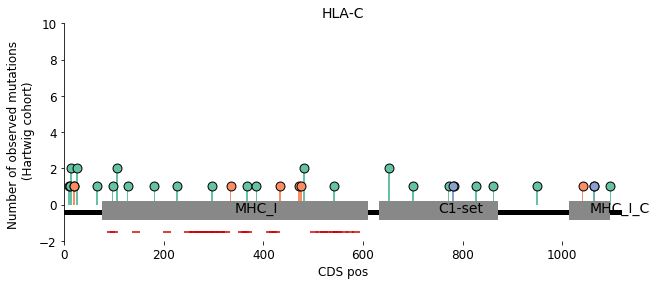

In [8]:
with open("../../external_data/P04439_HLAA.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-A"][1])
plot_hla("HLA-A",total_cds,d_h,summary,cohort="Hartwig")
with open("../../external_data/P01889_HLAB.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-B"][1])
plot_hla("HLA-B",total_cds,d_h,summary,cohort="Hartwig")
with open("../../external_data/P10321_HLAC.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-C"][1])
plot_hla("HLA-C",total_cds,d_h,summary,cohort="Hartwig")

### Plot synonymous variants

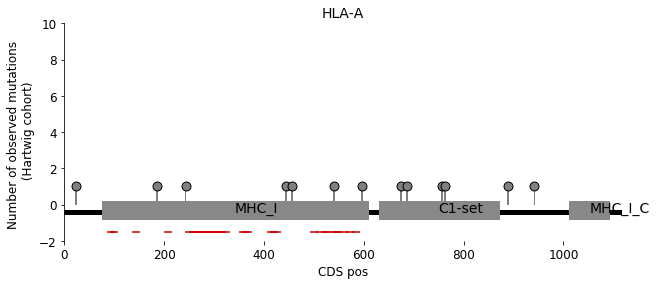

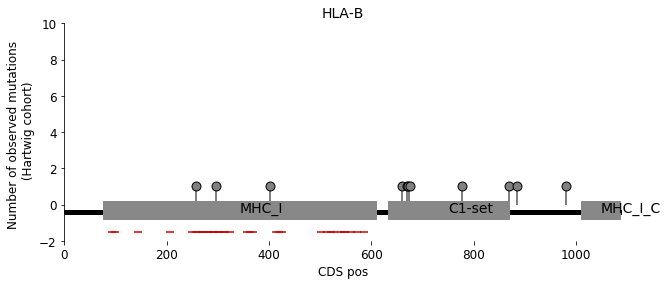

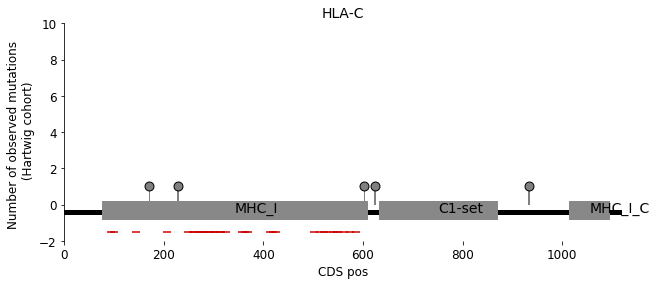

In [9]:
with open("../../data_external/P04439_HLAA.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-A"][1])
plot_hla("HLA-A",total_cds,d_h,summary,synonymous=True,cohort="Hartwig")
with open("../../data_external/P01889_HLAB.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-B"][1])
plot_hla("HLA-B",total_cds,d_h,summary,synonymous=True,cohort="Hartwig")
with open("../../data_external/P10321_HLAC.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-C"][1])
plot_hla("HLA-C",total_cds,d_h,summary,synonymous=True,cohort="Hartwig")

In [10]:
df_muts_hla[(df_muts_hla["gene"]=="HLA-A")&(df_muts_hla["csq"].str.contains("synonymous"))].merge(df_meta[["sample_id","sample_id_2","msi_status","cancer_type"]]).drop("sample_id",axis=1).rename(columns={"sample_id_2":"sample_id"}).sort_values("sample_id")

,gene,csq,protein_pos,cds_pos,purple_vaf,variant_cn,raw_vaf,position,ref,alt,type_mut,sample_id,msi_status,cancer_type
10,HLA-A,synonymous_variant,62,186,0.3409,0.682,0.211,29910646,C,T,synonymous,HMF000318A,MSI,Colorectum carcinoma
3,HLA-A,synonymous_variant,81,243,0.4354,0.836,0.314,29910703,G,A,synonymous,HMF000527A,MSS,Colorectum carcinoma
9,HLA-A,synonymous_variant,314,942,0.1459,0.717,0.100,29912323,C,T,synonymous,HMF000964A,MSI,Breast cancer
6,HLA-A,synonymous_variant,180,540,0.5142,1.030,0.478,29911241,G,A,synonymous,HMF001459A,MSS,Breast cancer
12,HLA-A,synonymous_variant,225,675,0.5875,1.190,0.413,29911954,G,C,synonymous,HMF002052A,MSS,Penile cancer
0,HLA-A,synonymous_variant,148,444,0.2403,1.180,0.208,29911145,C,T,synonymous,HMF002075A,MSS,Breast cancer
1,HLA-A,synonymous_variant,254,762,0.3676,1.460,0.315,29912041,C,G,synonymous,HMF002470A,MSS,Breast cancer
4,HLA-A,synonymous_variant,229,687,0.4582,0.915,0.325,29911966,C,A,synonymous,HMF003323A,MSI,Colorectum carcinoma
8,HLA-A,synonymous_variant,252,756,0.2291,0.912,0.138,29912035,G,A,synonymous,HMF003626A,MSS,Breast cancer
2,HLA-A,synonymous_variant,297,889,0.2987,0.618,0.122,29912168,A,C,synonymous,HMF004509A,MSI,CUP


### Process output LILAC for somatic mutations in HLA-I genes in PCAWG dataset

In [ ]:
lilac_pcawg="/home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/pcawg/lilac"

In [14]:
df_primary = df_pcawg[(df_pcawg["cohort"]=="PCAWG")&(df_pcawg["is_selected"])]
print (df_primary.shape[0])
l=[]
lenghts={}
for sample in tqdm(df_primary["sample_id"].values):
    if not(os.path.exists(f"{lilac_pcawg}/{sample}/{sample}.lilac.somatic.vcf.gz")):
        continue
    try:
        dq = pd.read_csv(f"{lilac_pcawg}/{sample}/{sample}.lilac.somatic.vcf.gz",sep="\t",skiprows=91)
    except:

        dq = pd.read_csv(f"{lilac_pcawg}/{sample}/{sample}.lilac.somatic.vcf.gz",sep="\t",skiprows=97)
    for i,r in dq.iterrows():
        csq,gene,cds_pos,protein_pos = map(r["INFO"].split("|").__getitem__,[1,3,12,13])
        caf = float(m.search(r["INFO"])[1])
        vcn = float(m1.search(r["INFO"])[1])
        vaf = float(r[sample+"T"].split(":")[2])
        pos,ref,alt=r["POS"],r["REF"],r["ALT"]
        if not(gene) in lenghts:
            lenghts[gene] = (protein_pos.split("/")[1],cds_pos.split("/")[1])
        l.append([gene,csq,sample,protein_pos.split("/")[0],cds_pos.split("/")[0],caf,vcn,vaf,pos,ref,alt])
df_muts_hla_primary = pd.DataFrame(l,columns=["gene","csq","sample_id","protein_pos","cds_pos","purple_vaf","variant_cn","raw_vaf","position","ref","alt"])
df_muts_hla_primary["type_mut"] = df_muts_hla_primary.apply(lambda row: get_type_mut(row["csq"]),axis=1)
summary_primary=df_muts_hla_primary.groupby(["gene","type_mut","cds_pos"]).agg({"sample_id":"count"}).reset_index().set_index(["gene"])

  0%|          | 0/1880 [00:00<?, ?it/s]

1880


100%|██████████| 1880/1880 [03:12<00:00,  9.78it/s]


### Plot non-synonymous mutations

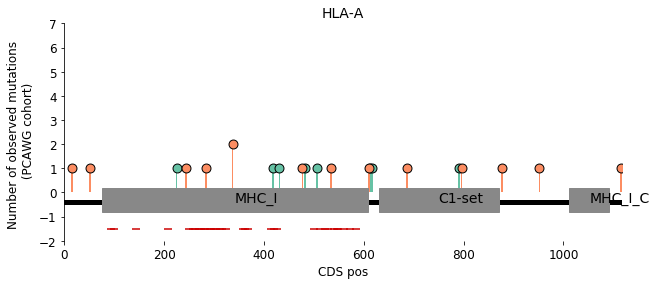

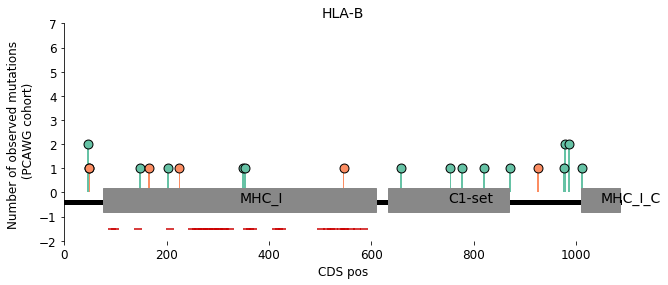

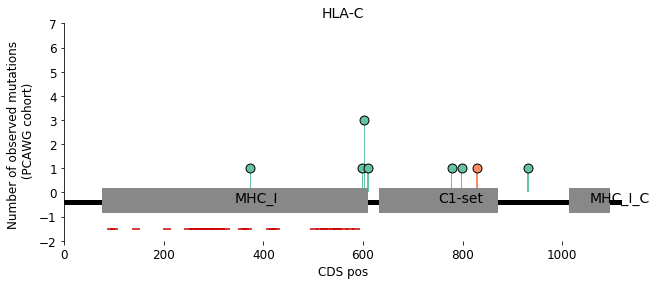

In [15]:
with open("../../external_data/P04439_HLAA.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-A"][1])
plot_hla("HLA-A",total_cds,d_h,summary_primary,cohort="PCAWG",ylim=5)
with open("../../external_data/P01889_HLAB.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-B"][1])
plot_hla("HLA-B",total_cds,d_h,summary_primary,cohort="PCAWG",ylim=5)
with open("../../external_data/P10321_HLAC.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-C"][1])
plot_hla("HLA-C",total_cds,d_h,summary_primary,cohort="PCAWG",ylim=5)

### Plot synonymous mutations

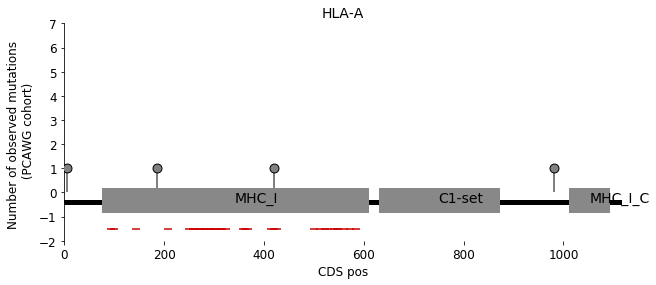

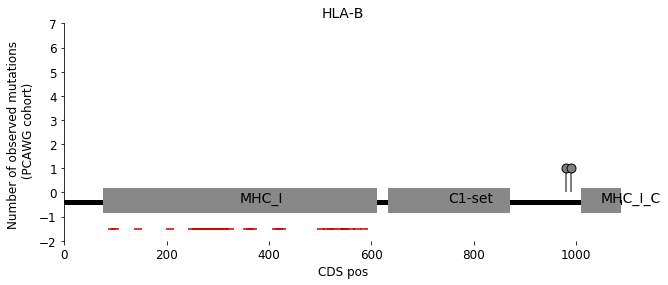

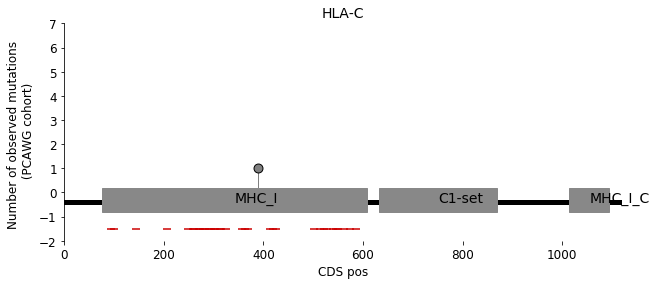

In [16]:
with open("../../external_data/P04439_HLAA.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-A"][1])
plot_hla("HLA-A",total_cds,d_h,summary_primary,cohort="PCAWG",ylim=5,synonymous=True)
with open("../../external_data/P01889_HLAB.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-B"][1])
plot_hla("HLA-B",total_cds,d_h,summary_primary,cohort="PCAWG",ylim=5,synonymous=True)
with open("../../external_datal/P10321_HLAC.json") as f:
    d_h=json.load(f)
total_cds=int(lenghts["HLA-C"][1])
plot_hla("HLA-C",total_cds,d_h,summary_primary,cohort="PCAWG",ylim=5,synonymous=True)